## Introduction

For our presentation we decided to focus on the environmental side of the neighborhoods. 

In [3]:
# Just import commands.
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import geopandas
%matplotlib inline

### ----- Yuqing -----

### Illegal Dump Sites

In order to find the most enviromentally firendly neighborhood. I choose the data of the illegal dump sites in the Allegheny County.

In [4]:
# show the first ten rows of the data
dumps = pd.read_csv('Datasets\illegaldumpsites.csv')
dumps.head(10)

,site_name,Status,City,Neighborhood,estimated_tons,location_description,latitude,longitude,Unnamed: 8
0,St. Martin Street,Surveyed,Pittsburgh,Allentown,0.5,NaN,40.42221971,-79.99022525,NaN
1,Brosville Street,Surveyed,Pittsburgh,Allentown,3,NaN,40.42370101,-79.98657393,NaN
2,McCain Street,Surveyed,Pittsburgh,Allentown,1,NaN,40.42427063,-79.99022675,NaN
3,Ceres Way,Surveyed,Pittsburgh,Allentown,0.5,NaN,40.42327242,-79.99248958,NaN
4,Eureka Street,Completed,Pittsburgh,Allentown,0.1,NaN,40.42372131,-79.99478912,NaN
5,222 Walter Street,Completed,Pittsburgh,Allentown,5,dump is in deteriorated garage,40.42022451,-79.99477699,NaN
6,Grimes and Elsinburg,Completed,Pittsburgh,Allentown,0.3,"residential street, across the street from a s...",40.41544068,-79.99297857,NaN
7,Parkwood Road Site 1,Surveyed,Pittsburgh,Arlington,3,NaN,40.41068203,-79.96578013,NaN
8,Parkwood Road Site 2,Surveyed,Pittsburgh,Arlington,4,NaN,40.41144932,-79.96714085,NaN
9,Parkwood Road Site 3,Completed,Pittsburgh,Arlington,2.5,NaN,40.41397095,-79.97727203,NaN


Since the data contains all the places in Allegeny County, I should pick out the data of Pittsburgh. What's more, I found some illegal sites were already been completed. I assume they had been removed. So I also need to delete the sites that status are completed.

In [5]:
# pick out the city of Pittsburgh and incompleted dump sites
dump_in_pitts = dumps.loc[dumps['City'] == 'Pittsburgh']
dump_in_pitts2 = dump_in_pitts.loc[dumps['Status'] != 'Completed']
dump_in_pitts2.head(10)

,site_name,Status,City,Neighborhood,estimated_tons,location_description,latitude,longitude,Unnamed: 8
0,St. Martin Street,Surveyed,Pittsburgh,Allentown,0.5,NaN,40.42221971,-79.99022525,NaN
1,Brosville Street,Surveyed,Pittsburgh,Allentown,3,NaN,40.42370101,-79.98657393,NaN
2,McCain Street,Surveyed,Pittsburgh,Allentown,1,NaN,40.42427063,-79.99022675,NaN
3,Ceres Way,Surveyed,Pittsburgh,Allentown,0.5,NaN,40.42327242,-79.99248958,NaN
7,Parkwood Road Site 1,Surveyed,Pittsburgh,Arlington,3,NaN,40.41068203,-79.96578013,NaN
8,Parkwood Road Site 2,Surveyed,Pittsburgh,Arlington,4,NaN,40.41144932,-79.96714085,NaN
11,Jonquil Street,Surveyed,Pittsburgh,Arlington,0.5,NaN,40.41609955,-79.9805603,NaN
12,Bassler Street,Surveyed,Pittsburgh,Arlington,0.5,NaN,40.41400146,-79.96459198,NaN
13,Azul Street,Surveyed,Pittsburgh,Arlington,1.5,NaN,40.41648095,-79.96574277,NaN
14,Rothman Street,Surveyed,Pittsburgh,Arlington,2,NaN,40.41384125,-79.97312164,NaN


In [6]:
# removed unecessary columns and leave 'Status' as 'count' to calculate the number of dump sites in each neighborhood
clean_dump_in_pitts = dump_in_pitts2.drop(['site_name', 'City', 'location_description','latitude', 'longitude', 'estimated_tons','Unnamed: 8'], axis=1)
# group the count from smallest to largest
dump_in_neighborhoods = clean_dump_in_pitts.groupby('Neighborhood').size().sort_values()
dump_in_neighborhoods.head(10)

Neighborhood
Crafton Heights          1
Chartiers City           1
Elliott                  1
Sharpsburg               1
Spring Garden            1
Crawford Roberts-Hill    1
Borough of Millvale      1
Downtown                 1
Highland Park/Larimer    1
Springdale               1
dtype: int64

From the data above, I can find that from 'Beltzhoover'to 'Perry South' neighborhood, the number of dump sites are over 10. So these neighborhoods can be wiped from our consideration about the most enviromentally friendly neighborhood in Pittsburgh.

I graph a bar chart to show the numbers of dump sites in each neighborhood

<AxesSubplot:xlabel='Neighborhood'>

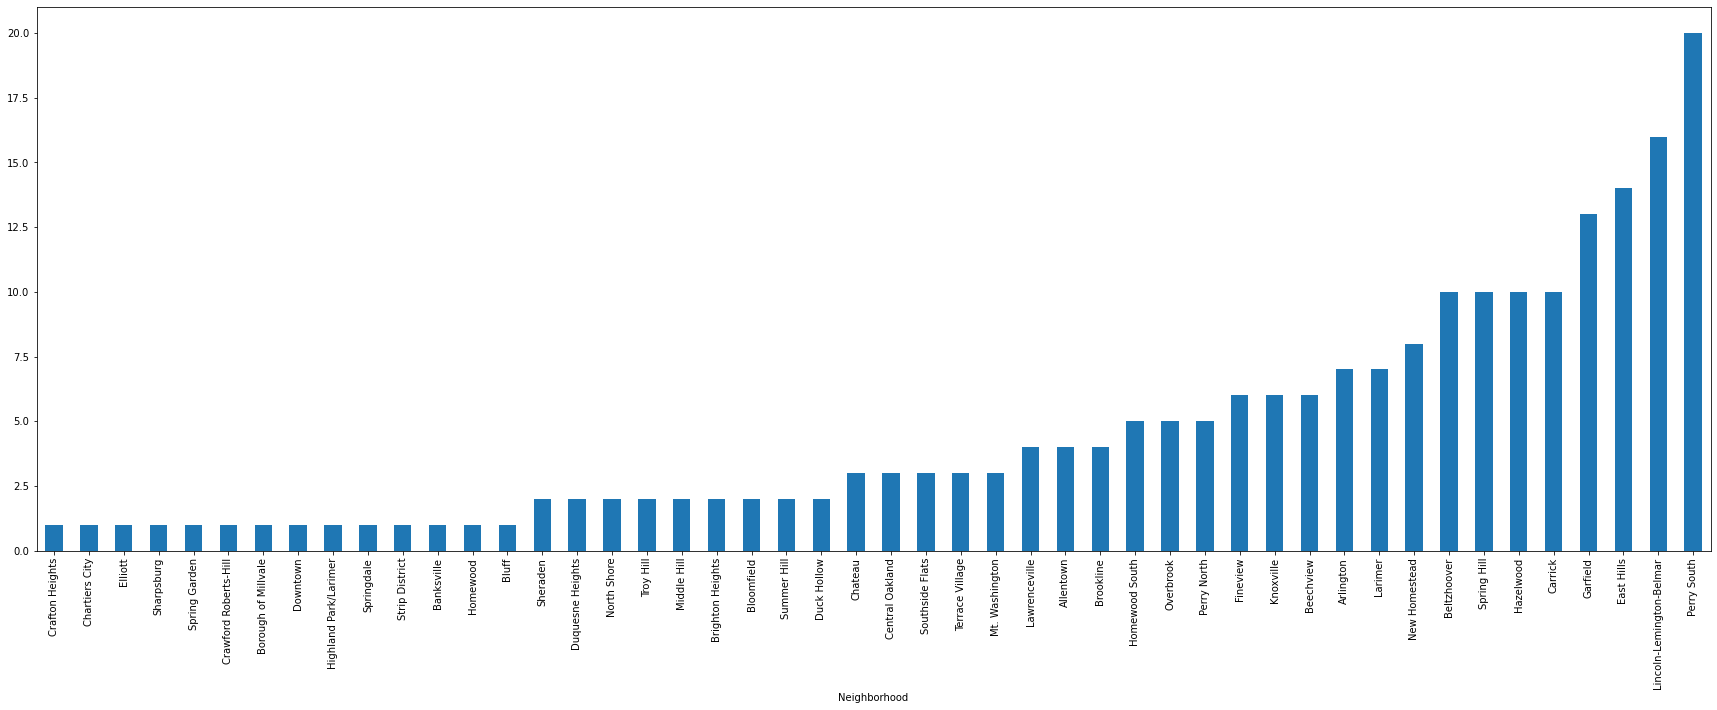

In [7]:
dump_in_neighborhoods.plot.bar(figsize=[30,10])

I also graph a map of the dump sites in each neighborhood to enhance visualization.

<AxesSubplot:>

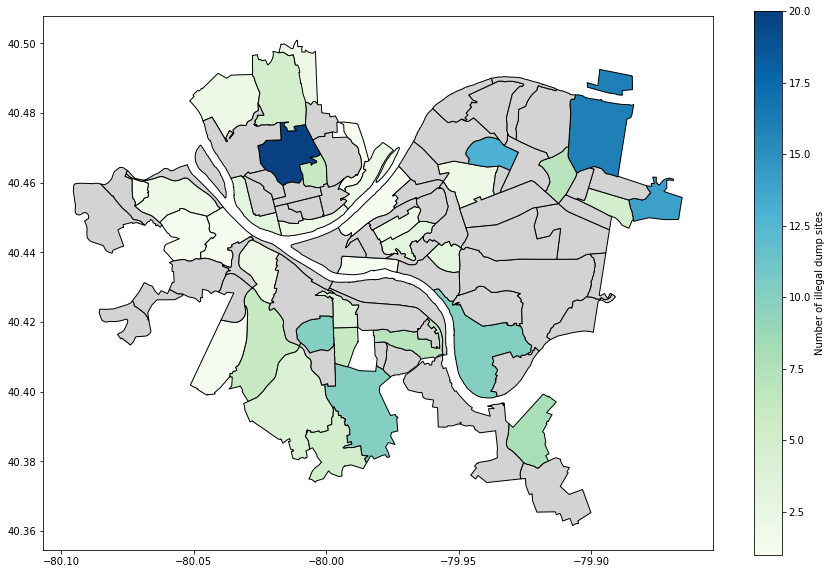

In [8]:
new = clean_dump_in_pitts.groupby('Neighborhood').count()
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
bin_map = neighborhoods.merge(new, how='left', left_on='hood', right_on='Neighborhood')
bin_map.plot(column='Status',
             cmap='GnBu',
             edgecolor="black",
             legend=True,
             legend_kwds={'label':"Number of illegal dump sites"},
             figsize=(15,10),
             missing_kwds={"color": "lightgrey"}
            )

### ----- Nafee -----

### Traffic in Neighborhoods

Traffic positively correlates with both air and noise pollution, less of it theoretically means a more environmentally sound neighborhood.

Here is some data about traffic in Pittsburgh:

In [9]:
# import dataset
traffic = pd.read_csv('Datasets\TrafficCountData.csv')
# print first 10 entries
traffic.head(10)

,id,device_id,record_oid,count_start_date,count_end_date,average_daily_car_traffic,average_daily_bike_traffic,counter_number,counter_type,speed_limit,...,longitude,latitude,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone
0,1011743669,85,1.445865e+09,2019-04-18,2019-04-26,4949.0,NaN,6,StatTrak,25.0,...,-79.967772,40.455733,Polish Hill,7.0,6,42003060500,6,6,2.0,2-6
1,1026101993,140,1.121444e+09,2019-01-24,NaN,NaN,NaN,NaN,Intersection Study,NaN,...,-79.952249,40.466157,Central Lawrenceville,7.0,9,42003090200,2,9,2.0,3-6
2,1032382575,11,1.539893e+09,2018-08-28,2018-09-04,NaN,NaN,NaN,NaN,35.0,...,-80.076469,40.460717,Windgap,2.0,28,42003563000,5,28,6.0,1-16
3,103627606,9,7.341951e+08,2018-07-17,2018-08-01,2741.0,NaN,NaN,StatTrak,25.0,...,-79.914335,40.437379,Squirrel Hill South,5.0,14,42003140800,3,14,4.0,2-18
4,1039546167,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-80.019211,40.490794,Perry North,1.0,26,42003260200,1,26,1.0,1-15
5,1041392556,76,5.713472e+08,2019-03-22,2019-03-29,1046.0,NaN,2,StatTrak,25.0,...,-80.014234,40.458106,Central Northside,6.0,25,42003250300,1,25,1.0,1-21
6,1047444948,17,1.366891e+09,2018-10-18,NaN,NaN,NaN,NaN,NaN,25.0,...,-79.942273,40.446282,Squirrel Hill North,8.0,14,42003140100,3,14,4.0,2-26
7,1053645660,87,8.042089e+08,2019-04-18,2019-04-26,3015.0,NaN,4,StatTrak,25.0,...,-79.964592,40.457119,Polish Hill,7.0,6,42003060500,6,6,2.0,2-6
8,1073440033,156,1.736165e+09,2017-07-28,NaN,NaN,NaN,NaN,Intersection Study,NaN,...,-79.960385,40.438983,Central Oakland,3.0,4,42003040500,3,4,4.0,2-14
9,1092885547,143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-79.920958,40.467294,East Liberty,9.0,11,42003111300,2,11,5.0,3-8


Here we are going to find the average daily car traffic across all neighborhoods. To do this we need to find the average traffic data value for every data entry that is the average car traffic for a given day, then sort them in descending order to see which neighborhoods are lowest in traffic.

In [10]:
# group data by neighborhood, get mean of average_daily_car_traffic on them, sort values, and drop any NaN values
trafficData = traffic.groupby('neighborhood')['average_daily_car_traffic'].mean().sort_values().dropna()
trafficData

neighborhood
Spring Hill-City View          63.000000
South Side Flats              115.000000
Lincoln Place                 126.000000
Lincoln-Lemington-Belmar      195.000000
Fineview                      419.000000
                                ...     
Strip District               9691.666667
North Shore                 10350.000000
Crafton Heights             11500.000000
East Hills                  13788.000000
Regent Square               16729.000000
Name: average_daily_car_traffic, Length: 62, dtype: float64

From this we see the average traffic for each neighborhood across the dates given in our dataset. From these results it shows that Spring Hill-City View has the lowest amount of car traffic.

Here is a bar graph of these results for a visualization:

<AxesSubplot:xlabel='neighborhood'>

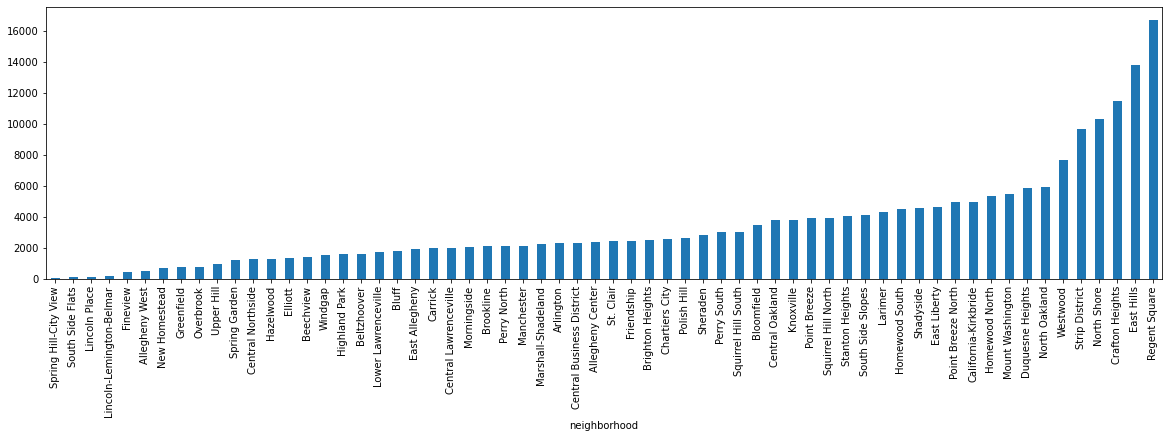

In [11]:
trafficData.plot.bar(figsize=[20,5])

From this we can see notably low relative car traffic in Spring Hill-City View, South Side Flats, Lincoln Place, and Lincoln-Lemington-Belmar with notably high relative car traffic in Westwood, Strip District, North Shore, Crafton Heights, East Hills, and Regent Square.

Here is a choropleth map of neighborhoods by their average car traffic:

<AxesSubplot:>

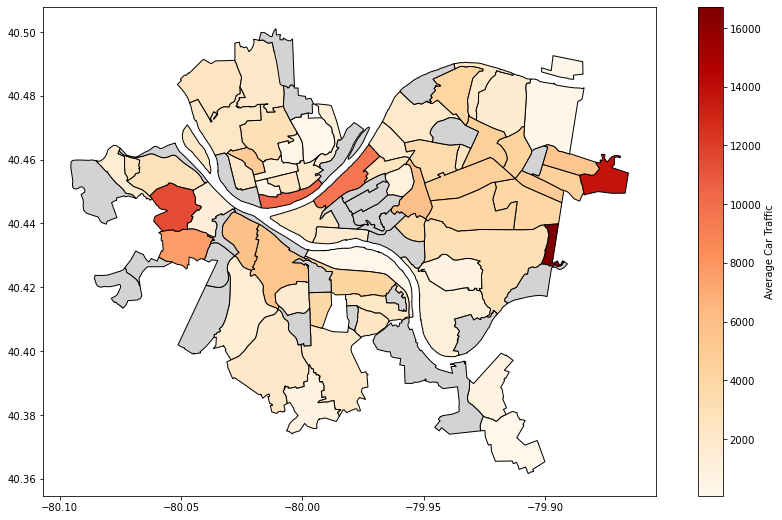

In [12]:
# read neighborhood dataset
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
# merge neighborgood and trafficData
trafficMap = neighborhoods.merge(trafficData, how='left', left_on='hood', right_on='neighborhood')
# plot
trafficMap.plot(column='average_daily_car_traffic',
             cmap='OrRd',
             edgecolor="black",
             legend=True,
             legend_kwds={'label':"Average Car Traffic"},
             figsize=(15, 9),
             missing_kwds={"color": "lightgrey"})

### ----- Kenny -----

### Smart Trash in Our Neighborhoods 

One of our main focal points in determining the best neighborhood is analyzing the environmental aspects of each area and trying to find some particular attributes that we would desire in our ideal neighborhood. In this case, it is the idea of general cleanliness of the neighborhood. Nobody wants to live in an area where the streets are full of litter with sidewalks cluttered with trash. One proposed method is the idea of "smart waste management" and its implementation of smart trash cans. Pittsburgh has adopted this system with the deployment of trash cans that monitor the volume of trash in each bin. This allows for munipalities and trash management workers to optimize their time to empty bins that are more full compared to rotating on a weekly schedule. While this can not account for those who litter ignorantly, it does minimize the excess waste as trash bins are more likely to be empty for use.

### Analysis

To start, we will take a brief look at the information provided by the dataset in the TrashContainers.

In [13]:
containers  = pd.read_csv('Datasets\TrashContainers.csv')
containers.head(10)

,container_id,receptacle_model_id,assignment_date,last_updated_date,group_name,address,city,state,zip,neighborhood,dpw_division,council_district,ward,fire_zone,x,y
0,1,74,2017-09-14T13:24:40,2021-04-21T02:17:15,1st Division,122 E North Ave,Pittsburgh,Pennsylvania,15212,Central Northside,1.0,1.0,22.0,1-6,-80.004018,40.456073
1,3,74,2017-09-14T13:24:40,2021-04-21T02:29:22,1st Division,1300 Federal St,Pittsburgh,Pennsylvania,15212,Central Northside,1.0,1.0,22.0,1-6,-80.006872,40.456625
2,4,74,2017-09-14T13:24:40,2021-04-21T02:19:23,1st Division,110 Federal St,Pittsburgh,Pennsylvania,15212,Allegheny Center,1.0,1.0,22.0,1-6,-80.006250,40.454520
3,5,74,2017-09-19T12:22:45,2021-04-21T08:05:20,1st Division,490 E North Ave,Pittsburgh,Pennsylvania,15212,Central Northside,1.0,1.0,22.0,1-6,-80.002083,40.456444
4,6,74,2017-09-19T12:22:46,2021-04-21T02:09:16,1st Division,1501 Brighton Rd,Pittsburgh,Pennsylvania,15212,California-Kirkbride,1.0,6.0,25.0,1-21,-80.015758,40.457025
5,7,74,2017-09-19T12:22:46,2021-04-21T08:05:21,1st Division,3113 Brighton Rd,Pittsburgh,Pennsylvania,15212,Marshall-Shadeland,1.0,1.0,27.0,1-14,-80.029040,40.473820
6,8,74,2017-09-19T12:22:46,2021-04-21T02:05:22,1st Division,1729 Brighton Rd,Pittsburgh,Pennsylvania,15212,California-Kirkbride,1.0,6.0,25.0,1-21,-80.016706,40.459364
7,9,74,2017-09-19T12:22:46,2021-04-21T02:22:19,1st Division,710 W North Ave,Pittsburgh,Pennsylvania,15212,Allegheny Center,1.0,1.0,22.0,1-21,-80.014095,40.453969
8,10,74,2017-09-19T12:22:46,2021-04-21T09:05:20,1st Division,919 Fulton St,Pittsburgh,Pennsylvania,15233,Manchester,1.0,6.0,21.0,1-8,-80.023932,40.451663
9,11,74,2017-09-19T12:22:46,2021-04-21T13:00:23,1st Division,3900 Perrysville Ave,Pittsburgh,Pennsylvania,15214,Perry North,1.0,1.0,26.0,1-15,-80.018440,40.489410


Certain columns such as receptacle model id,the dates, and fire zones are not particularly relevant in our analysis as we are going to focus on concentrated areas of smart trash containers. We can drop these columns to refine the data a little bit.

In [14]:
containers.drop('receptacle_model_id', inplace=True, axis=1)
containers.drop('assignment_date', inplace=True, axis=1)
containers.drop('last_updated_date', inplace=True, axis=1)
containers.drop('fire_zone', inplace=True, axis=1)
containers.head(10)

,container_id,group_name,address,city,state,zip,neighborhood,dpw_division,council_district,ward,x,y
0,1,1st Division,122 E North Ave,Pittsburgh,Pennsylvania,15212,Central Northside,1.0,1.0,22.0,-80.004018,40.456073
1,3,1st Division,1300 Federal St,Pittsburgh,Pennsylvania,15212,Central Northside,1.0,1.0,22.0,-80.006872,40.456625
2,4,1st Division,110 Federal St,Pittsburgh,Pennsylvania,15212,Allegheny Center,1.0,1.0,22.0,-80.006250,40.454520
3,5,1st Division,490 E North Ave,Pittsburgh,Pennsylvania,15212,Central Northside,1.0,1.0,22.0,-80.002083,40.456444
4,6,1st Division,1501 Brighton Rd,Pittsburgh,Pennsylvania,15212,California-Kirkbride,1.0,6.0,25.0,-80.015758,40.457025
5,7,1st Division,3113 Brighton Rd,Pittsburgh,Pennsylvania,15212,Marshall-Shadeland,1.0,1.0,27.0,-80.029040,40.473820
6,8,1st Division,1729 Brighton Rd,Pittsburgh,Pennsylvania,15212,California-Kirkbride,1.0,6.0,25.0,-80.016706,40.459364
7,9,1st Division,710 W North Ave,Pittsburgh,Pennsylvania,15212,Allegheny Center,1.0,1.0,22.0,-80.014095,40.453969
8,10,1st Division,919 Fulton St,Pittsburgh,Pennsylvania,15233,Manchester,1.0,6.0,21.0,-80.023932,40.451663
9,11,1st Division,3900 Perrysville Ave,Pittsburgh,Pennsylvania,15214,Perry North,1.0,1.0,26.0,-80.018440,40.489410


This allows use to see what specifications we are working with in the smart trash dataset. The next step is to sum up the amount of smart trash cans in each neighborhood.

In [15]:
bins = containers.groupby('neighborhood').count() # forming a dataset that is used to produce a choropleth map of the bins

containers['neighborhood'].value_counts().head(20)

Shadyside                78
East Liberty             72
Squirrel Hill South      67
South Side Flats         66
Bloomfield               60
North Shore              55
Strip District           49
Central Oakland          44
Carrick                  41
Middle Hill              33
Bluff                    32
Lower Lawrenceville      31
Homewood South           30
Central Lawrenceville    29
East Allegheny           28
Mount Washington         25
Brighton Heights         24
Crawford-Roberts         21
Squirrel Hill North      21
Hazelwood                20
Name: neighborhood, dtype: int64

This is getting showing the numerical value of the sum of trash bins in each neighborhood. I want to visualize this into a choropleth graph to see the concentrations of smart trash bins with the corresponding neighborhood.

<AxesSubplot:>

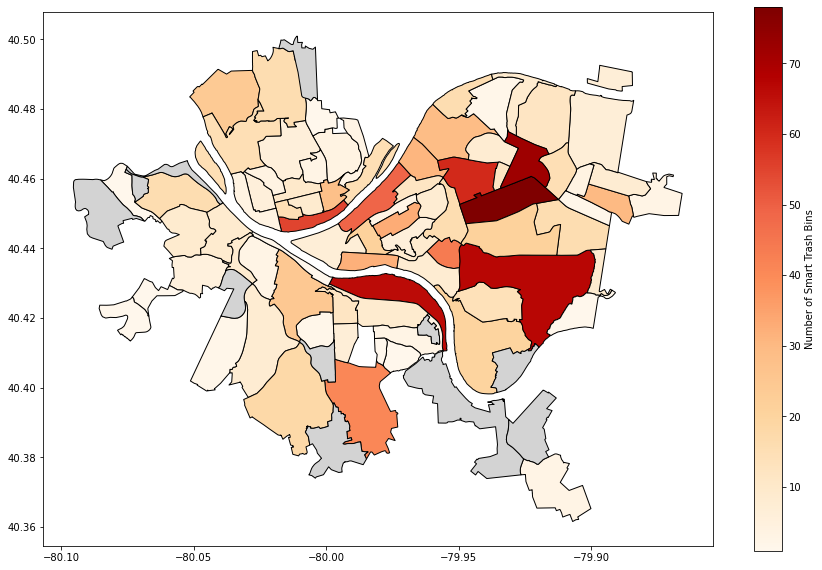

In [16]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
bin_map = neighborhoods.merge(bins, how='left', left_on='hood', right_on='neighborhood')
bin_map.plot(column='ward',
             cmap='OrRd',
             edgecolor="black",
             legend=True,
             legend_kwds={'label':"Number of Smart Trash Bins"},
             figsize=(15,10),
             missing_kwds={"color": "lightgrey"}
            )


In the end, Shadyside is the best neighborhood based solely on the concentration of the smart trash bins located there. This does not come as a surprise as Shadyside is quite reknown for its attractive and cleanliness.

### ----- Anderis -----

Pittsburgh is a pretty large city. Despite all the high rises and parking complexes, there are still quite a lot of trees throughout each neighborhood of the city. For my part of the Project I am going to be looking at the number of (legally documented and cared for) trees that are within each neighborhood. Throughout this file will have information on the numerics of these trees, as well as their general wellbeing. All of these factors will go into my metric to decide which neighborhood is truly the best in Pittsburgh. (based on this arbitrary metric :D).

<AxesSubplot:>

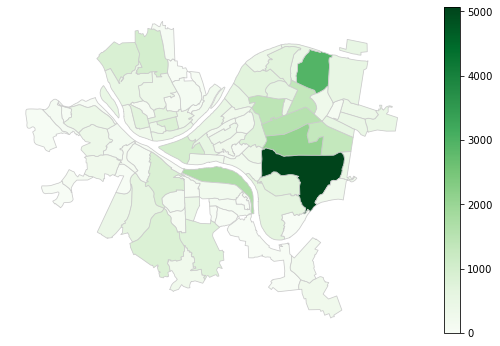

In [17]:
# Initializing datasets and changing some of the indexes to better fit my needs
trees    = pd.read_csv('Datasets\Trees.csv', low_memory=False)
fname    = "Datasets/Neighborhoods.geojson"
pitt_map = geopandas.read_file(fname)
pitt_map = pitt_map.rename(columns={'Neighborhood_2010_HOOD' : 'Neighborhood'})
df       = pd.DataFrame(data=trees['neighborhood'].value_counts(sort=False))
df       = df.rename(columns={'neighborhood' : 'count'}).reset_index()
df       = df.rename(columns={'index' : 'neighborhood'})

# Sorted both datasets so they would match up
pitt_map = pitt_map.sort_values(by='Neighborhood').reset_index()
df       = df.sort_values(by='neighborhood').reset_index()

# merges the two data sets together with a concatination.
frame    = [pitt_map,df]
merged   = pd.concat(frame, axis=1, ignore_index=False, sort=False)

# general variables to help setup the Choropleth map
variable   = 'count'
vmin, vmax = 0, 5073
fig, ax    = plt.subplots(1, figsize=(10, 6))

# turns off the axis lines
ax.axis('off')

# sets up the legend for the map
sm   = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

# writes the map
merged.plot(column=variable, cmap='Greens', linewidth=0.8, vmin=vmin , vmax=vmax , ax=ax, edgecolor='0.8')

This is the first of my Choropleth maps!

This one is quite simple, it just maps out all the different neighborhoods and colors them in based on total number of trees within the neighborhood. Obviously Squirrel Hilll South, the largest neighborhood, is top of the list on this one.

In [18]:
# Lists out the neighborhoods with the top 10 highest tree counts.
merged[['neighborhood','count']].sort_values(by='count', ascending=False).head(10)

,neighborhood,count
76,Squirrel Hill South,5073
39,Highland Park,2941
75,Squirrel Hill North,2083
71,South Side Flats,1693
67,Shadyside,1558
9,Bloomfield,1436
28,East Liberty,1366
62,Point Breeze,1316
60,Perry North,1007
16,Central Business District,1002


Now do we get all the information we want from that map? of course not! Obviously the alrgest neighborhood has the most amount of trees. So lets try incorporating the areas of the neighborhoods into the calculations!

<AxesSubplot:>

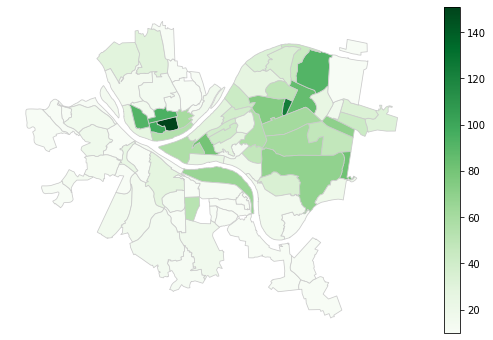

In [19]:
# Calculates the amount of trees per square kilometer within each neighborhood
TSK = (merged['count']).div(merged['SHAPE_Area'].mul(100000)).to_frame('Trees per Square Kilometer')

# Concatinates the datasets. Be prepared for lots of mergedx variables.. I'm not the best at naming :D
merged2 = pd.concat([merged, TSK], axis=1, ignore_index=False, sort=False)

# once again just variable stuff for the map
variable = 'Trees per Square Kilometer'
vmin,vmax = 10, 151
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# legend stuff
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

# draws out the map
merged2.plot(column=variable, cmap='Greens', linewidth=0.8, vmin=vmin , vmax=vmax , ax=ax, edgecolor='0.8')

Now the map is looking a lot different! accounting for the total number of trees mixed with the area has made it so Allegheny Center, a decently small neighborhood, is shown to have the highest density of trees per square kilometer. In fact Squirrel Hill, our highest before, does not even fall into the top 10 now.

In [20]:
merged2[['neighborhood','Trees per Square Kilometer']].sort_values(by='Trees per Square Kilometer', ascending=False).head(10)

,neighborhood,Trees per Square Kilometer
0,Allegheny Center,150.730121
33,Friendship,123.953330
1,Allegheny West,99.357446
18,Central Northside,94.641829
48,Manchester,92.052254
39,Highland Park,91.936289
28,East Liberty,85.460371
65,Regent Square,82.097723
23,Crawford-Roberts,79.950480
9,Bloomfield,74.367717


Our new top 10 has a lot of smaller neighborhoods starting to gain in spots. Of course not every tree is created equal. So how do all of these neighborhoods fair when the health of the trees are a concern?

The beginning of this next section of code uses the conditions of the trees in order to calulate a total number of healthy trees. I used a scoring system from Dead equaling -2 trees, all the way up to Excellent equalling 1.4 trees. This way neighborhoods that take more care of their trees gain more of an advantage.

<AxesSubplot:>

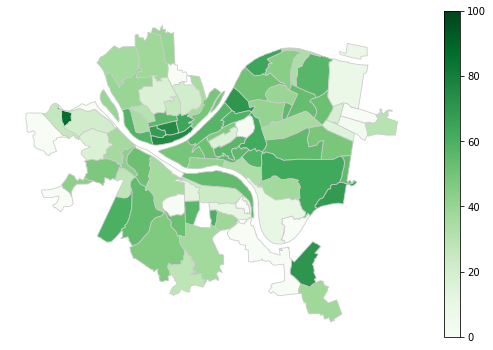

In [21]:
# list to hold the condition values.
cond_list = []

# code to ammend a list with all the values based on condition of the trees.
for x in trees['condition']:
    if x != x:
        cond_list.append(-1)
    elif x == 'Dead':
        cond_list.append(-2)
    elif x == 'Critical':
        cond_list.append(0.2)
    elif x == 'Poor':
        cond_list.append(0.4)
    elif x == 'Fair':
        cond_list.append(0.6)
    elif x == 'Good':
        cond_list.append(1.0)
    elif x == 'Very Good':
        cond_list.append(1.2)
    elif x == 'Excellent':
        cond_list.append(1.4)
    else:
        cond_list.append(x)

# adding the values into a DataFrame
cond_val = pd.DataFrame().append(cond_list)
cond_val.columns = ['Tree Health']

# merging the dataframe into the Tree.csv file DataFrame
tree_merge = pd.concat([trees,cond_val], axis=1, ignore_index=False, sort=False)

# groups all of the different values based on the neighborhood they reside and sums the scores together.
tree_health = tree_merge.groupby(by='neighborhood').sum().sort_values('neighborhood', ascending = True)['Tree Health']

# flips the columns and rows to better match later DataFrames.
tree_health = pd.DataFrame().append(tree_health).transpose()
tree_health = tree_health.reset_index()

# Hey look! another mergex variable. Sadly, theres still more later.
merged3 = pd.concat([merged2,tree_health], axis=1, ignore_index=False, sort=False)

# more empty lists to store things!
count_list = []
health_list = []
calc_list = []

# fills the first two lists with the original tree counts and the sum of Tree Health.
for x in merged3['count']:
    count_list.append(x)
for x in merged3['Tree Health']:
    health_list.append(x)

# fills a list with the calulations of what percent of trees are healthy within each neighborhood.
for x in range(90):
    calc_list.append((((health_list[x]) / (count_list[x]))) * 100)

# puts it into a DataFrame
perc_health = pd.DataFrame().append(calc_list)
perc_health.columns = ['Tree Health Percentage']

# Another mergex variable!
merged4 = pd.concat([merged3,perc_health], axis=1, ignore_index=False, sort=False)

# variables for the Choropleth map :D
variable = 'Tree Health Percentage'
vmin,vmax = 0, 100
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# Legends never die
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

# makes the map
merged4.plot(column=variable, cmap='Greens', linewidth=0.8, vmin=vmin , vmax=vmax , ax=ax, edgecolor='0.8')

So now we have a map based on the percentages of healthy trees within each of the neighborhoods. Some of the neighborhoods did really well with Chartiers City getting an astounding 86.4% on the scale of healthy trees. And while there may be highs like this, Oh there are far, far worse lows. Poor Hays somehow managed to pull of a -200% on the scale of healthy trees. Actually in total 9 of the neighborhoods all scored a negative number for this section. A negative in this case means that they just have more dead trees than alive ones.

In [22]:
merged4[['neighborhood','Tree Health Percentage']].sort_values(by='Tree Health Percentage', ascending = False).head(10)

,neighborhood,Tree Health Percentage
20,Chartiers City,86.486486
56,North Shore,74.660832
0,Allegheny Center,74.648212
54,New Homestead,70.710383
47,Lower Lawrenceville,70.590551
81,Swisshelm Park,68.571429
1,Allegheny West,68.186528
25,East Allegheny,64.245524
85,Upper Lawrenceville,64.075067
76,Squirrel Hill South,63.153952


In [23]:
merged4[['neighborhood','Tree Health Percentage']].sort_values(by='Tree Health Percentage', ascending = True).head(10)

,neighborhood,Tree Health Percentage
37,Hays,-200.000000
35,Glen Hazel,-80.000000
4,Arlington Heights,-32.000000
31,Fairywood,-29.677419
26,East Carnegie,-22.500000
70,South Shore,-20.000000
57,Northview Heights,-16.666667
30,Esplen,-6.666667
40,Homewood North,-0.347395
8,Beltzhoover,0.823529


Yeah the low scores for here are abysmal. As another note there was a section of the datasets that had the value "NaN" which through looking at the data appeared to coincide with where there were simply stumps left of trees. So stumps are actually classified differently than simply being "Dead" within these sets. So the low scores ( expecially Hays ) had a lot of either Dead trees, or Stumps where trees used to be. (well as of like March 7, 2021 when this was last updated)

But anyway, we now have the percentage of healthy trees within each neighborhood! so does that mean Chartiers City gets to take home the Golden Tree Crown? Not quite yet. We need to once again account for the area of each of these neighborhoods. Then we will finally be able to crown the Truest Healthy Tree filled neighborhood in Pittsburgh!

<AxesSubplot:>

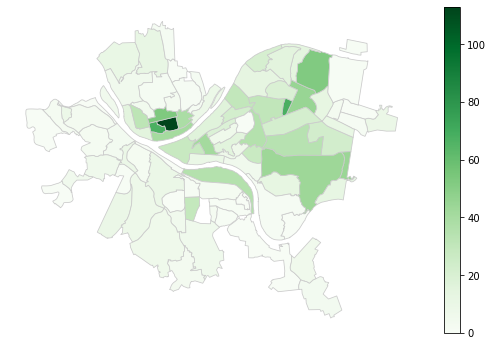

In [24]:
# Calculates The number of healthy trees per Square Kilometer
HTSK = (merged4['Tree Health']).div(merged4['SHAPE_Area'].mul(100000)).to_frame('Health of Trees per Square Kilometer')

# hey the final mergex variable. They grow up so fast.
merged5 = pd.concat([merged4, HTSK], axis=1, ignore_index=False, sort=False)

# more map variables. 
variable = 'Health of Trees per Square Kilometer'
vmin,vmax = 0, 113
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# There have been many legends carried down through these long few days. Legends that one day, the Healthy 
# trees may soon rise up and take their rightful place among the streets of Pittsburgh.
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

# The Final Map Creation :D
merged5.plot(column=variable, cmap='Greens', linewidth=0.8, vmin=vmin , vmax=vmax , ax=ax, edgecolor='0.8')

And now we finally have our winner. It goes to Alleghey Center! This neighborhood has proven to have not only the highest density of trees, but also the highest density of healthy tree too! We can finally crown the best Neighborhood in Pittsburgh based on these arbitrary measurements I have compounded together.

In [25]:
merged5[['neighborhood','Health of Trees per Square Kilometer']].sort_values(by='Health of Trees per Square Kilometer',ascending = False).head(10)

,neighborhood,Health of Trees per Square Kilometer
0,Allegheny Center,112.517340
33,Friendship,68.003125
1,Allegheny West,67.748393
18,Central Northside,53.190393
39,Highland Park,52.123281
28,East Liberty,45.457910
65,Regent Square,44.567335
76,Squirrel Hill South,43.628991
23,Crawford-Roberts,41.101303
56,North Shore,40.870919


As a bit of bonus information. I already shows one of the lists earlier, but heres the rest of the Worst neighborhoods for each category I tested above! So lets get right into it by starting with tree count!

In [26]:
merged[['neighborhood','count']].sort_values(by='count', ascending=True).head(10)

,neighborhood,count
37,Hays,1
70,South Shore,2
35,Glen Hazel,2
30,Esplen,3
4,Arlington Heights,5
57,Northview Heights,6
26,East Carnegie,8
77,St. Clair,12
53,Mt. Oliver,13
66,Ridgemont,31


Next we have the worst in tree density!

In [27]:
merged2[['neighborhood','Trees per Square Kilometer']].sort_values(by='Trees per Square Kilometer', ascending=True).head(10)

,neighborhood,Trees per Square Kilometer
37,Hays,0.020802
35,Glen Hazel,0.159603
70,South Shore,0.343528
30,Esplen,0.476494
26,East Carnegie,0.677856
57,Northview Heights,0.696739
31,Fairywood,1.167341
4,Arlington Heights,1.382913
77,St. Clair,1.409432
66,Ridgemont,3.068378


And finally, the worst of the worst when based on The density of healthy trees they have!

In [28]:
merged5[['neighborhood','Health of Trees per Square Kilometer']].sort_values(by='Health of Trees per Square Kilometer',ascending = True).head(10)

,neighborhood,Health of Trees per Square Kilometer
4,Arlington Heights,-0.442532
31,Fairywood,-0.346437
26,East Carnegie,-0.152518
35,Glen Hazel,-0.127683
40,Homewood North,-0.117247
57,Northview Heights,-0.116123
70,South Shore,-0.068706
37,Hays,-0.041604
30,Esplen,-0.031766
8,Beltzhoover,0.121132


So the Absolute worst neighborhood for trees is Hays, coming up in last place in 3 out of the 4 different measurements.

Thats all for this Data, Hopefully more trees will continue to be placed around the city.

## Final Conclusions

So we've gone through the data, but which neighborhood truly reigns supreme?
To figure that out we did some basic addition by applying a point total from 1-10 based on the placement of each neighborhood in our respective datasets.

So the overall winnder of the best neighborhood in Pittsburgh (base off of a few arbitrary metrics) is

# *Drum Roll*

## East Liberty

This neighborhood didn't get any number 1 spots on the datasets, but it did make up for it by generally good. Scoring a good number two placement based on Trash Containers and a strong 6th place in number of trees. Waste sites didn't help it's score at all, but it still made managed to come out on top. It didn't rank well in traffic but not terrible relatively.

## Top 5 scores

### East Liberty     - 16
### Allegheny Center - 13
### Squirrel Hill S  - 13
### Shadyside        - 12
### Friendship       - 12